In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn import set_config

In [2]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
plt.style.use('seaborn')

# Load Data

In [3]:
sale_data = pd.read_csv('data_available/sale_data_post_out.csv', sep=',')
sale_data.shape

(7387, 15)

In [4]:
sale_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7387 entries, 0 to 7386
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   daft_id          7387 non-null   int64  
 1   url              7387 non-null   object 
 2   name             7387 non-null   object 
 3   price            7387 non-null   float64
 4   sale_type        7387 non-null   object 
 5   floor_area       7387 non-null   int64  
 6   entered_renewed  7387 non-null   object 
 7   views            7387 non-null   float64
 8   type_house       7387 non-null   object 
 9   type             7387 non-null   object 
 10  scraping_date    7387 non-null   object 
 11  latitude         7387 non-null   float64
 12  longitude        7387 non-null   float64
 13  bedroom          7387 non-null   int64  
 14  bathroom         7387 non-null   int64  
dtypes: float64(4), int64(4), object(7)
memory usage: 865.8+ KB


In [5]:
sale_data.sample()

,daft_id,url,name,price,sale_type,floor_area,entered_renewed,views,type_house,type,scraping_date,latitude,longitude,bedroom,bathroom
4422,15979990,https://www.daft.ie/for-sale/detached-house-fo...,"Forramoyle West, Barna, Co. Galway",550000.0,For Sale by Private Treaty,198,2021-10-19,8052.0,house,buy,2021-10-19,53.262403,-9.177427,5,3


-----------

-----

-------

# Split Data

In [6]:
def split_train_test(df, test_ratio=.2):
    shuffled_indices = np.random.permutation(len(df))
    test_set_size = int(len(df) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return df.iloc[train_indices], df.iloc[test_indices]

In [7]:
train_set, test_set = split_train_test(sale_data, .2)
print(train_set.shape, test_set.shape)

(5910, 15) (1477, 15)


Estos los guardaria en dos archivos

-----------------

In [8]:
y_train = train_set['price'].copy()
y_train.shape

(5910,)

In [9]:
print(train_set.shape)
X_train = train_set[['floor_area', 'bedroom', 'bathroom']]
print(X_train.shape)

(5910, 15)
(5910, 3)


In [10]:
def split_x_y(train_set, test_set, features, target='price'):
    y_train = train_set[target].copy()
    X_train = train_set[features].copy()
    y_test = test_set[target].copy()
    X_test = test_set[features].copy()
    print('X_train:', X_train.shape, '\n' + 
          'X_test:', X_test.shape, '\n' + 
          'y_train:', y_train.shape, '\n' + 
          'y_test:', y_test.shape, '\n')
    return X_train, X_test, y_train, y_test

In [11]:
features = ['floor_area', 'bedroom', 'bathroom']

X_train, X_test, y_train, y_test = split_x_y(train_set, test_set, features, target='price')

X_train: (5910, 3) 
X_test: (1477, 3) 
y_train: (5910,) 
y_test: (1477,) 



In [12]:
X_train.columns

Index(['floor_area', 'bedroom', 'bathroom'], dtype='object')

# Transform Data

## Transformation Pipeline

In [13]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder


In [14]:
num_pipe = Pipeline([
    ('std_scaler', StandardScaler()),
    ])

In [15]:
cat_pipe = Pipeline([
    ('one_hot_encoder', OneHotEncoder()),
    ])

In [16]:
num_features = ['floor_area', 'bedroom', 'bathroom']

In [48]:
preprocessor = ColumnTransformer([
    ('num', num_pipe, num_features),  # ['place']
    ])
preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('std_scaler',
                                                  StandardScaler())]),
                                 ['floor_area', 'bedroom', 'bathroom'])])

## Linear Regression

In [18]:
from sklearn.linear_model import LinearRegression

In [19]:
lr = Pipeline(steps=[('preprocessor', preprocessor),
                     ('regressor', LinearRegression())
                    ])

In [20]:
lr.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('std_scaler',
                                                                   StandardScaler())]),
                                                  ['floor_area', 'bedroom',
                                                   'bathroom'])])),
                ('regressor', LinearRegression())])

In [21]:
y_pred = lr.predict(X_test)

In [22]:
def metrics_regression(y_test, y_pred, squared=False):
    
    r2_score = metrics.r2_score(y_test, y_pred)
    mae = metrics.mean_absolute_error(y_test, y_pred)
    mape = metrics.mean_absolute_percentage_error(y_test, y_pred)
    mse = metrics.mean_squared_error(y_test, y_pred)
    rmse = metrics.mean_squared_error(y_test, y_pred, squared=squared)
    
    print(f'R²: {r2_score}')
    print(f'MAE: {mae}')
    print(f'MAPE: {mape}')
    #print(f'MSE: {mse}')
    print(f'RMSE: {rmse}')

In [23]:
from sklearn import metrics

metrics_regression(y_test=y_test, y_pred=y_pred, squared=False)

R²: 0.3310600883739735
MAE: 161117.34964739715
MAPE: 0.5296515941233745
RMSE: 242485.2700294838


In [24]:
def cross_validate_custom(estimator, scoring_dict, X_train, y_train, cv=10, return_train_score=False):
    from sklearn.model_selection import cross_validate
    estimator = estimator
    scoring_dict = scoring_dict

    scores = cross_validate(estimator, X=X_train, y=y_train, scoring=scoring_dict, cv=cv, 
                            return_train_score=return_train_score)
    print(scores.keys())
    return scores

In [25]:
def scores_statistics(estimator, scoring_dict, X_train, y_train, cv=10, return_train_score=False, time_info=False):
    
    scores = cross_validate(estimator, X=X_train, y=y_train, scoring=scoring_dict, cv=cv, 
                            return_train_score=return_train_score)
    
    if time_info:
        fit_time_mean = np.mean(scores['fit_time'])
        fit_time_std = np.std(scores['fit_time'])
        score_time_mean = np.mean(scores['score_time'])
        score_time_std = np.std(scores['score_time'])
        #time_list = []    
        print('fit_time mean:', fit_time_mean)
        print('fit_time std:', fit_time_std)
        print('score_time mean:', score_time_mea)
        print('score_time std:', score_time_std)
    
    
    for key in scoring_dict:
        try:
            mean = np.mean(scores['test_' + key])
            std = np.std(scores['test_' + key])
            print(key, 'mean:', mean)
            print(key, 'std:', std, '\n')
        except:
            continue
    return scores

In [26]:
from sklearn.model_selection import cross_validate

scoring = {'r2': 'r2', 
           'MAE': 'neg_mean_absolute_error', 
           'MAPE': 'neg_mean_absolute_percentage_error', 
           'RMSE': 'neg_root_mean_squared_error'}

lr = Pipeline(steps=[('preprocessor', preprocessor),
                     ('regressor', LinearRegression())
                    ])

scores_statistics(estimator=lr, scoring_dict=scoring, 
                  X_train=X_train, y_train=y_train, cv=5, return_train_score=False)

r2 mean: 0.27212409962240613
r2 std: 0.011038143781119497 

MAE mean: -169083.0443155238
MAE std: 3265.874062671591 

MAPE mean: -0.5390899850709874
MAPE std: 0.025115478000243087 

RMSE mean: -261952.4222711789
RMSE std: 7116.383193420296 



{'fit_time': array([0.0063107 , 0.00543809, 0.0049305 , 0.00476503, 0.00498605]),
 'score_time': array([0.00384712, 0.00323558, 0.00376868, 0.00311613, 0.00369358]),
 'test_r2': array([0.26484047, 0.26636925, 0.27290313, 0.29320842, 0.26329924]),
 'test_MAE': array([-171606.68689616, -163914.27439346, -166830.76031399,
        -172792.62476855, -170270.87520547]),
 'test_MAPE': array([-0.57813362, -0.52332383, -0.54032753, -0.5500589 , -0.50360604]),
 'test_RMSE': array([-267538.81121186, -255952.18283646, -251592.41391577,
        -264127.17613021, -270551.52726159])}

### Recursive Feature Elimination

In [27]:
from sklearn import feature_selection

In [28]:
lr = Pipeline(steps=[('preprocessor', preprocessor),
                     ('regressor', LinearRegression())
                    ])

In [29]:
rfe = feature_selection.RFE(estimator=LinearRegression(), n_features_to_select=1, step=1)

In [30]:
rfe.fit(X_train, y_train)

RFE(estimator=LinearRegression(), n_features_to_select=1)

In [31]:
X_train.columns

Index(['floor_area', 'bedroom', 'bathroom'], dtype='object')

In [32]:
rfe.support_

array([False, False,  True])

In [33]:
rfe.ranking_

array([3, 2, 1])

In [34]:
X_train.sample()

,floor_area,bedroom,bathroom
4158,230,5,3


In [108]:
from numpy import mean
from numpy import std
from sklearn.datasets import make_regression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline
# define dataset
#X, y = make_regression(n_samples=1000, n_features=10, n_informative=5, random_state=1)
# create pipeline

rfe = RFE(estimator=LinearRegression(), n_features_to_select=3, step=1)

lr = Pipeline(steps=[('preprocessor', preprocessor),
                           ('s',rfe), 
                           ('regressor', LinearRegression())
                          ])

#pipeline = Pipeline(steps=[('s',rfe),('m',model)])
# evaluate model
#cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(estimator=lr, X=X_train, y=y_train, 
                           scoring='neg_mean_absolute_error', cv=5, n_jobs=-1, 
                           error_score='raise')
# report performance
print('MAE: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))
n_scores

MAE: -169083.044 (3265.874)


array([-171606.68689616, -163914.27439346, -166830.76031399,
       -172792.62476855, -170270.87520547])

In [110]:
scores_rfe = []
for i in range(1, X_train.shape[1] + 1): # i = 1,..., 13
    rfe = RFE(estimator=LinearRegression(), n_features_to_select=i, step=1)

    lr = Pipeline(steps=[('preprocessor', preprocessor),
                           ('s',rfe), 
                           ('regressor', LinearRegression())
                          ])

#pipeline = Pipeline(steps=[('s',rfe),('m',model)])
# evaluate model
#cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
    n_scores = cross_val_score(estimator=lr, X=X_train, y=y_train, 
                           scoring='neg_mean_absolute_error', cv=5, n_jobs=-1, 
                           error_score='raise')
# report performance
    print('MAE: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))
    scores_rfe.append(np.mean(n_scores))
scores_rfe

MAE: -169367.862 (2912.185)
MAE: -169897.470 (2899.959)
MAE: -169083.044 (3265.874)


[-169367.86214770522, -169897.47043830532, -169083.0443155238]

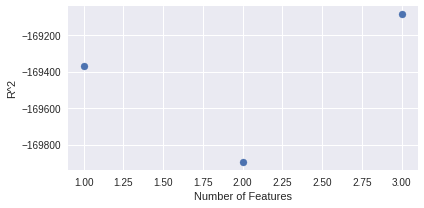

In [112]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3))
ax.scatter(range(1, X_train.shape[1] + 1), scores_rfe) # x=1a13, y=scores

ax.set_xlabel('Number of Features')
ax.set_ylabel('R^2')
plt.tight_layout()

### Sequential Feature Selector

## Grid Search

In [129]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_jobs': [-1]},
    {'n_jobs': [1]},
]

#lr = Pipeline(steps=[('preprocessor', preprocessor),
 #                         # ('s',rfe), 
  #                         ('regressor', LinearRegression())
   #                       ])
    
preprocessor = ColumnTransformer([
    ('num', num_pipe, [0, 1, 2]), 
    ])

num_pipe = Pipeline([
    ('std_scaler', StandardScaler()),
    ])

X_train_prepared = preprocessor.fit_transform(X_train)
y_train_prepared = num_pipe.fit_transform(y_train.values.reshape(-1, 1))

X_test_prepared = preprocessor.transform(X_test)
y_test_prepared = num_pipe.transform(y_test.values.reshape(-1, 1))

gs = GridSearchCV(LinearRegression(), param_grid, cv=5, 
                           scoring='neg_mean_absolute_error', return_train_score=True)

gs.fit(X_train_prepared, y_train_prepared)

GridSearchCV(cv=5, estimator=LinearRegression(),
             param_grid=[{'n_jobs': [-1]}, {'n_jobs': [1]}],
             return_train_score=True, scoring='neg_mean_absolute_error')

In [130]:
gs.best_params_

{'n_jobs': -1}

In [131]:
gs.best_estimator_

LinearRegression(n_jobs=-1)

In [132]:
gs.cv_results_

{'mean_fit_time': array([0.00092988, 0.00080318]),
 'std_fit_time': array([1.08933905e-04, 5.89313628e-06]),
 'mean_score_time': array([0.00032415, 0.00031219]),
 'std_score_time': array([2.51743828e-05, 3.03624352e-05]),
 'param_n_jobs': masked_array(data=[-1, 1],
              mask=[False, False],
        fill_value='?',
             dtype=object),
 'params': [{'n_jobs': -1}, {'n_jobs': 1}],
 'split0_test_score': array([-0.55860569, -0.55860569]),
 'split1_test_score': array([-0.53356573, -0.53356573]),
 'split2_test_score': array([-0.54305933, -0.54305933]),
 'split3_test_score': array([-0.5624661, -0.5624661]),
 'split4_test_score': array([-0.55425743, -0.55425743]),
 'mean_test_score': array([-0.55039086, -0.55039086]),
 'std_test_score': array([0.01063091, 0.01063091]),
 'rank_test_score': array([1, 1], dtype=int32),
 'split0_train_score': array([-0.54726136, -0.54726136]),
 'split1_train_score': array([-0.55440546, -0.55440546]),
 'split2_train_score': array([-0.55211741, -0.552

In [134]:
pd.DataFrame(gs.cv_results_).transpose()

,0,1
mean_fit_time,0.00093,0.000803
std_fit_time,0.000109,0.000006
mean_score_time,0.000324,0.000312
std_score_time,0.000025,0.00003
param_n_jobs,-1,1
params,{'n_jobs': -1},{'n_jobs': 1}
split0_test_score,-0.558606,-0.558606
split1_test_score,-0.533566,-0.533566
split2_test_score,-0.543059,-0.543059
split3_test_score,-0.562466,-0.562466
